<a href="https://colab.research.google.com/github/willjhliang/traffic-sign-recognition/blob/main/pipeline_cnn_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# Download dataset from github repo
!git clone --quiet https://github.com/willjhliang/traffic-sign-recognition.git
!mv traffic-sign-recognition/* .
!rm -r traffic-sign-recognition

In [1]:
from copy import deepcopy
import itertools

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')

import torch
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils import data
import torchvision

from constants import K, S, class_size, validation_ratio, random_seed
from data import load_data, consolidate_data, split_validation, visualize_data, compare_class_dist
from augment import augment_dataset, visualize_augmentation
from dimensionality_reduction import run_pca, visualize_pca, visualize_pca_per_channel
from torch_utils import load_torch_data, train_model, evaluate_model
from evaluation import generate_confusion_matrix, get_classification_report, generate_class_comparison

# Dataset

In [2]:
train_data = load_data('data/filtered_images/train_small')
test_data = load_data('data/filtered_images/test')
labels = pd.read_csv("data/filtered_labels.csv")

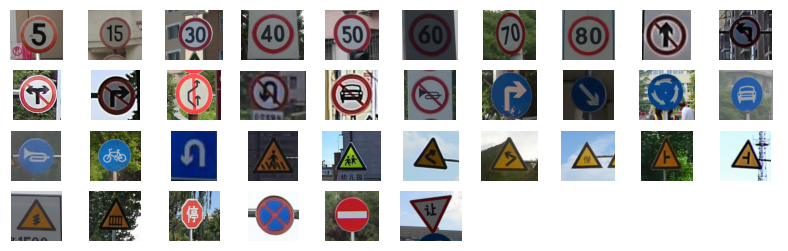

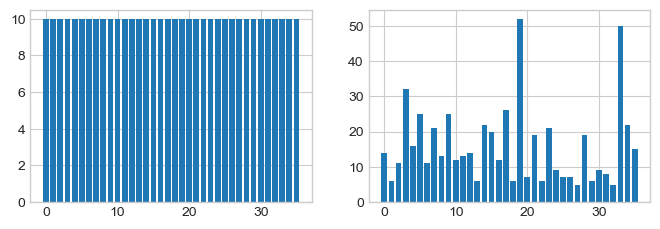

In [3]:
visualize_data(train_data)
compare_class_dist(train_data, test_data)

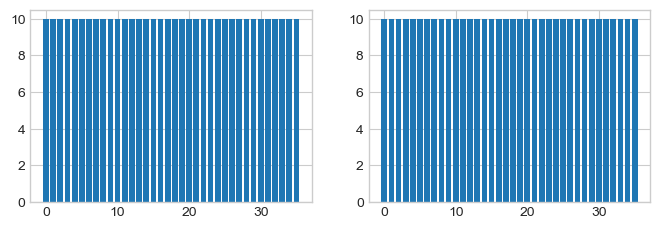

In [4]:
original_train_data = deepcopy(train_data)
train_data = augment_dataset(train_data)
compare_class_dist(original_train_data, train_data)

In [5]:
X_train, _, y_train = consolidate_data(train_data)
X_test, _, y_test = consolidate_data(test_data)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (360, 3, 32, 32)
X_test shape: (572, 3, 32, 32)


# Models

## Convolutional Neural Network Variations

In [6]:
class CNN_XXS(nn.Module):
    def __init__(self):
        super(CNN_XXS, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(16 * 16 * 32, 64)
        self.dropout_2 = nn.Dropout(0.25)
        self.linear_2 = nn.Linear(64, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [ ]:
class CNN_XS(nn.Module):
    def __init__(self):
        super(CNN_XS, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(8 * 8 * 32, 128)
        self.dropout_2 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.max_pool2d(x)
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [ ]:
class CNN_S(nn.Module):
    def __init__(self):
        super(CNN_S, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(16 * 16 * 32, 128)
        self.dropout_2 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

In [ ]:
class CNN_M(nn.Module):
    def __init__(self):
        super(CNN_M, self).__init__()
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_3 = nn.BatchNorm2d(64)
        self.conv_4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.batch_norm_4 = nn.BatchNorm2d(64)
        self.dropout_1 = nn.Dropout(0.5)

        self.linear_1 = nn.Linear(8 * 8 * 64, 128)
        self.dropout_2 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(128, K)

    def forward(self, x):
        x = self.relu(self.batch_norm_1(self.conv_1(x)))
        x = self.relu(self.batch_norm_2(self.conv_2(x)))
        x = self.max_pool2d(x)

        x = self.relu(self.batch_norm_3(self.conv_3(x)))
        x = self.relu(self.batch_norm_4(self.conv_4(x)))
        x = self.dropout_1(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout_2(x)
        x = self.linear_2(x)
        return x

# Training and Evaluation

========== Convolutional Neural Network (Extra Extra Small) ==========
Epoch: 001, Loss:   45.2909, Train F1: 0.0279, Validation F1: 0.0474
Epoch: 002, Loss:   38.0661, Train F1: 0.0473, Validation F1: 0.0132
Epoch: 003, Loss:   37.3944, Train F1: 0.0498, Validation F1: 0.0393
Epoch: 004, Loss:   35.5585, Train F1: 0.0644, Validation F1: 0.0000
Epoch: 005, Loss:   34.6698, Train F1: 0.0681, Validation F1: 0.0342
Epoch: 006, Loss:   33.4890, Train F1: 0.1087, Validation F1: 0.0185
Epoch: 007, Loss:   31.8380, Train F1: 0.1454, Validation F1: 0.0519
Epoch: 008, Loss:   30.0960, Train F1: 0.1215, Validation F1: 0.0653
Epoch: 009, Loss:   29.9133, Train F1: 0.1389, Validation F1: 0.0705
Epoch: 010, Loss:   28.7857, Train F1: 0.1385, Validation F1: 0.0698


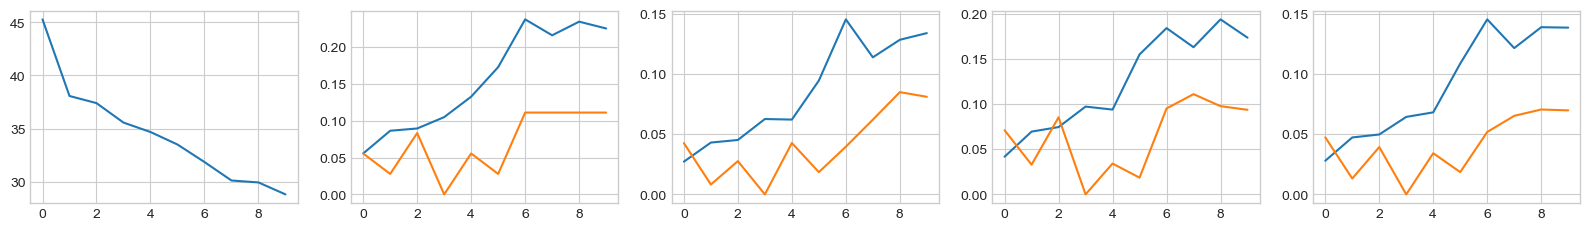

In [7]:
print('========== Convolutional Neural Network (Extra Extra Small) ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN_XXS(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

In [ ]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)

In [ ]:
print('========== Convolutional Neural Network (Extra Small) ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN_XS(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

In [ ]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)

In [ ]:
print('========== Convolutional Neural Network (Small) ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN_S(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

In [ ]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)

In [ ]:
print('========== Convolutional Neural Network (Medium) ==========')
train_loader, val_loader, test_loader = load_torch_data(X_train, y_train, X_test, y_test)
model = train_model(CNN_M(), train_loader, val_loader, 10, 1e-3)
(y_pred_cnn, y_label_cnn), _ = evaluate_model(model, test_loader)

In [ ]:
cnn_reportdict, cnn_df = get_classification_report(y_label_cnn, y_pred_cnn, labels)
generate_class_comparison(cnn_reportdict, 'f1-score', labels)